In [1]:
%load_ext autoreload
%autoreload 2
from MODM_Tool_Modules import gathering_data_function as gt
from MODM_Tool_Modules.PROMETHEE_Modules import PROMETHEE_data_processing as pm_process
from MODM_Tool_Modules.PROMETHEE_Modules import PROMETHEE_plotting_results_function as pm_plot
from MODM_Tool_Modules.PROMETHEE_Modules import PROMETHEE_saving_results as pm_save 
from MODM_Tool_Modules.PROMETHEE_Modules import PROMETHEE_sensitivity_analysis as pm_sens

In [2]:
decision_matrix, normalized_matrix, data_filename, weights, normalized_weights, beneficial_criteria, non_beneficial_criteria = gt.gathering_data(
    'C:/Users/Virgi/OneDrive/Bureau/MODM_tool_project/Tool/Data/data_input/optimal_pareto_points2.csv')

       Profit (€/h)  Impact on Ecosystems (species·yr/h) · 10^4  \
Point                                                             
1            566.37                                       5.532   
2           2701.83                                       5.576   
3           4223.16                                       5.625   
4           5381.57                                       5.674   
5           6091.79                                       5.720   
6           6221.99                                       5.766   
7           6271.55                                       5.814   
8           6272.59                                       5.862   
9           6273.62                                       5.910   
10          6274.65                                       5.958   
11          5843.28                                       5.890   
12          5324.84                                       5.853   
13          4575.07                                       5.81

In [3]:
user_input = input(
    "Do you want to save the results of this run? (yes/no): ").strip().lower()
directory = None
if user_input == 'yes':
    directory = pm_save.directory_creation(data_filename)

In [4]:
preference_functions = pm_process.define_preference_functions(decision_matrix)

In [5]:
net_flows, ranked_alternatives, ranks = pm_process.PROMETHEE_data_processing(decision_matrix, normalized_matrix, normalized_weights, preference_functions)

c:\Users\Virgi\OneDrive\Bureau\MODM_tool_project\Tool\Scripts\MODM_Tool_Modules\PROMETHEE_Modules\PROMETHEE_plotting_results_function.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


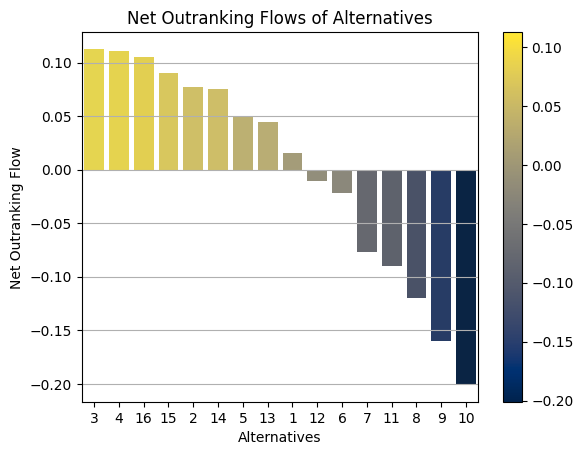

Point
3     0.112811
4     0.110432
16    0.105283
15    0.090168
2     0.076802
14    0.075005
5     0.049385
13    0.044278
1     0.015828
12   -0.010340
6    -0.021581
7    -0.077250
11   -0.090244
8    -0.119602
9    -0.159980
10   -0.200996
dtype: float64


In [6]:
pm_plot.results_visualization_promethee(net_flows, weights, user_input, directory, ranked_alternatives)

Initial weight for Profit (€/h): 5
Initial weight for Impact on Ecosystems (species·yr/h) · 10^4: 5
Initial weight for Impact on Resources (USD2013/h) · 10^-4: 5


100%|██████████| 1000/1000 [02:12<00:00,  7.57it/s]


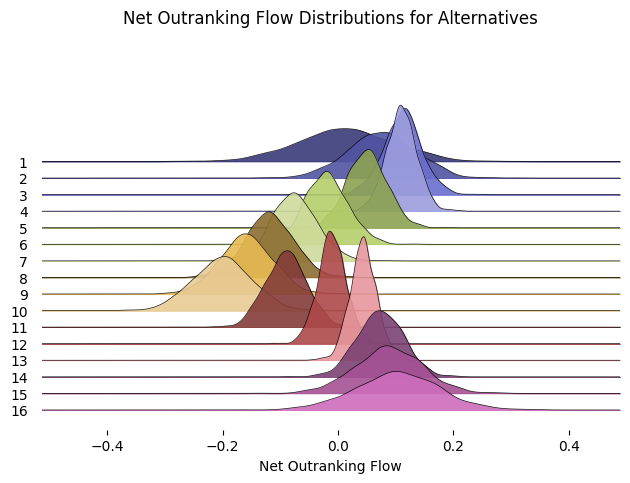

c:\Users\Virgi\OneDrive\Bureau\MODM_tool_project\Tool\Scripts\MODM_Tool_Modules\PROMETHEE_Modules\PROMETHEE_sensitivity_analysis.py:283: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


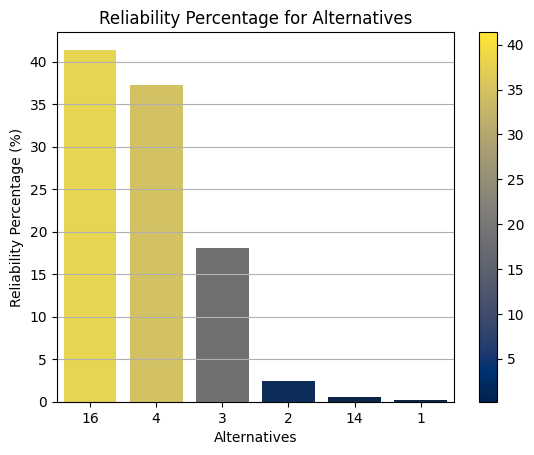

In [7]:
user_input2 = input(
    "Do you want to run a sensitivity analysis? (yes/no): ").strip().lower()
if user_input2 == 'yes':
    uncertainties, net_flows_df, ranks_df, filtered_top_serie, top_serie = pm_sens.sensitivity_analysis(pm_process.PROMETHEE_data_processing, weights, 100000, 0, 10, decision_matrix, normalized_matrix, user_input, directory, preference_functions)

In [8]:
if user_input == 'yes':
    pm_save.save_run_results(
        directory,
        decision_matrix,
        preference_functions,
        ranked_alternatives,
        weights,
        beneficial_criteria,
        non_beneficial_criteria,
    )
    
if user_input2 == 'yes' and user_input == 'yes':
    pm_save.save_sensitivity_results(
        directory,
        uncertainties,
        net_flows_df,
        ranks_df,
        top_serie)